<a href="https://colab.research.google.com/github/tsubauaaa/AITrialTraining/blob/main/Training10/AITraining10_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# データセットの説明

https://www.kaggle.com/uwrfkaggler/ravdess-emotional-speech-audio

```
Filename identifiers
Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
Vocal channel (01 = speech, 02 = song).
Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
Repetition (01 = 1st repetition, 02 = 2nd repetition).
Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).
```

# 課題2
1. wav2vecを内包する新たなモデルを作成  
last_hidden_stateをtransformer or LSTMにいれる
2. 学習


In [1]:
!pip install transformers

In [2]:
 # Google Driveをマウントする
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# 各音声ファイルのリストを取得

from pathlib import Path

audio_dir = Path('/content/drive/My Drive/Colab Notebooks/AITraining/RAVDESS/')
audio_files = audio_dir.glob("**/*.wav")
audio_file_list = list(audio_files)
print(audio_file_list)
print(len(audio_file_list))

[PosixPath('/content/drive/My Drive/Colab Notebooks/AITraining/RAVDESS/Actor_10/03-01-02-02-02-01-10.wav'), PosixPath('/content/drive/My Drive/Colab Notebooks/AITraining/RAVDESS/Actor_10/03-01-04-01-02-01-10.wav'), PosixPath('/content/drive/My Drive/Colab Notebooks/AITraining/RAVDESS/Actor_10/03-01-04-01-01-01-10.wav'), PosixPath('/content/drive/My Drive/Colab Notebooks/AITraining/RAVDESS/Actor_10/03-01-04-02-02-01-10.wav'), PosixPath('/content/drive/My Drive/Colab Notebooks/AITraining/RAVDESS/Actor_10/03-01-01-01-01-02-10.wav'), PosixPath('/content/drive/My Drive/Colab Notebooks/AITraining/RAVDESS/Actor_10/03-01-03-02-01-01-10.wav'), PosixPath('/content/drive/My Drive/Colab Notebooks/AITraining/RAVDESS/Actor_10/03-01-02-02-01-01-10.wav'), PosixPath('/content/drive/My Drive/Colab Notebooks/AITraining/RAVDESS/Actor_10/03-01-01-01-02-02-10.wav'), PosixPath('/content/drive/My Drive/Colab Notebooks/AITraining/RAVDESS/Actor_10/03-01-03-01-01-01-10.wav'), PosixPath('/content/drive/My Drive/C

In [4]:
# モデル定義
from transformers import Wav2Vec2Processor, Wav2Vec2Model
import torch.nn.functional as F
import torch.nn as nn
import torch

class Wav2VecClassifier(nn.Module):
    def __init__(self, hidden_size=512, num_classes=8, device='cpu', sr=16000):
        super(Wav2VecClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.sr = sr
        self.device = device
        self.processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
        self.model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")
        self.lstm = nn.LSTM(768, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        input_values = self.processor(x, return_tensors="pt", sampling_rate=self.sr).input_values
        # (batch_size, seq_len)に次元入れ替え(batch first対応)
        input_values = torch.squeeze(input_values.permute(1, 2, 0)).to(self.device)
        hidden_states = self.model(input_values).last_hidden_state
        lstm_out, lstm_hidden = self.lstm(hidden_states)
        # lstm_hiddenの最後をhidden_sizeに平す
        out = self.fc(lstm_hidden[0].view(-1, self.hidden_size))
        out = F.relu(out)
        out = F.softmax(out)
        return out

In [5]:
import librosa
import numpy as np

# 生データのデータセットクラス
class AudioRawDataset(torch.utils.data.Dataset):
    def __init__(self, audio_file_list, transform = None, num_classes=8, sr=16000):
        self.transform = transform
        self.file_path_list = audio_file_list
        self.label = [int(x.name.split('-')[2]) - 1 for x in audio_file_list]
        self.sr = sr
        self.datanum = len(self.label)

    def __len__(self):
        return self.datanum

    def __getitem__(self, idx):
        audio_file_path = self.file_path_list[idx]
        out_label = self.label[idx]
        out_data, _ = librosa.load(audio_file_path, sr=self.sr)

        if self.transform:
            out_data = self.transform(out_data)

        return out_data, out_label

In [6]:
##### targetがdataの長さが入っている気がする #####
# # (最大シーケンス長×バッチサイズ×特徴量次元数)のTensorを適当にゼロ埋めして返す
# class PadCollate:
#     """
#     a variant of callate_fn that pads according to the longest sequence in
#     a batch of sequences
#     """

#     def __init__(self, dim=1):
#         """
#         args:
#             dim - the dimension to be padded (dimension of time in sequences)
#         """
#         self.dim = dim

#     def pad_collate(self, batch):
#         '''
#         Padds batch of variable length

#         note: it converts things ToTensor manually here since the ToTensor transform
#         assume it takes in images rather than arbitrary tensors.
#         '''
#         ## get sequence lengths
#         lengths = torch.tensor([len(data) for data, target in batch])
#         ## padd
#         batch = [torch.Tensor(data) for data, target in batch]
#         batch = torch.nn.utils.rnn.pad_sequence(batch)
#         return batch, lengths

#     def __call__(self, batch):
#         return self.pad_collate(batch)


In [7]:
# # (最大シーケンス長×バッチサイズ×特徴量次元数)のTensorを適当にゼロ埋めして返す
from tensorflow import keras

class PadCollate(object):
    '''
    Yields a batch from a list of Items
    Args:
    test : Set True when using with test data loader. Defaults to False
    percentile : Trim sequences by this percentile
    '''
    def __init__(self,test=False,percentile=100):
        self.test = test
        self.percentile = percentile
    def __call__(self, batch):
        if not self.test:
            data = [item[0] for item in batch]
            target = [item[1] for item in batch]
        else:
            data = batch
        lens = [len(x) for x in data]
        max_len = np.percentile(lens, self.percentile)
        data = keras.preprocessing.sequence.pad_sequences(data, maxlen=int(max_len))
        data = torch.tensor(data, dtype=torch.float32)
        if not self.test:
            target = torch.tensor(target,dtype=torch.int64)
            return [data,target]
        return [data]

In [8]:
# tuple(data, target)
audio_dataset = AudioRawDataset(audio_file_list)
n_samples = len(audio_dataset)
train_size = int(len(audio_dataset) * 0.8)
val_size = n_samples - train_size
train_dataset, val_dataset = torch.utils.data.random_split(audio_dataset, [train_size, val_size])

In [9]:
print(f'data: {train_dataset[1][0]}, data shape: {train_dataset[1][0].shape}') # data
print(train_dataset[1][1]) # target type=int

data: [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -3.6451067e-06
  1.2300668e-05  0.0000000e+00], data shape: (53921,)
3


In [10]:
# Tensor
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True, collate_fn=PadCollate())
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False, drop_last=True, collate_fn=PadCollate())

In [11]:
# # イテレータ化
# train_dataiter = iter(train_loader)
# # データ取得
# data, target = train_dataiter.next()
# print(data.shape, target.shape) # data: (batch_size, seq_len), target: (batch_size)
# print(data.dtype, target.dtype) # data: (batch_size, seq_len), target: (batch_size)
# print(data, target) # data: (batch_size, seq_len), target: (batch_size)

In [12]:
import torch.optim as optim
from tqdm.notebook import tqdm
import librosa
import os

# device = torch.device('cuda')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'device: {device}')
model = Wav2VecClassifier(device=device)
model.to(device)
model.train()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

n_epochs = 2
losses = []
for epoch in tqdm(range(n_epochs)):
    total_loss = 0
    total_size = 0
    for data, target in train_loader:
        # data, target = data.transpose(1, 0), target.to(device)
        data, target = data, target.to(device)
        optimizer.zero_grad()
        output = model(data)
        # print(f'output: {output}, target: {target}')
        loss = criterion(output, target)
        total_loss += loss.item()
        total_size += data.size(0)
        loss.backward()
        optimizer.step()
    losses.append(total_loss)
    print("epoch", epoch, "\t" , "loss", total_loss)

device: cuda:0


Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


epoch 0 	 loss 149.72090554237366
epoch 1 	 loss 149.71806597709656



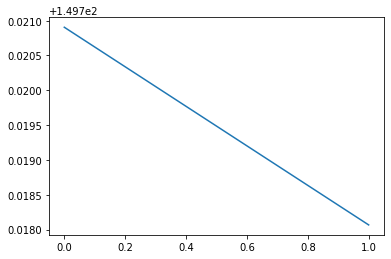

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(losses)

In [14]:
from sklearn.metrics import classification_report
pred = []
Y = []
for data, target in val_loader:
    with torch.no_grad():
        data, target = data, target.to(device)
        # print(data, data.shape)
        output = model(data)
    pred += [int(l.argmax()) for l in output]
    Y += [int(l) for l in target]

print(classification_report(Y, pred))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


              precision    recall  f1-score   support

           0       0.14      0.14      0.14        14
           1       0.00      0.00      0.00        31
           2       0.14      0.48      0.22        42
           3       0.18      0.07      0.10        45
           4       0.36      0.12      0.18        33
           5       0.00      0.00      0.00        48
           6       0.00      0.00      0.00        39
           7       0.10      0.28      0.15        36

    accuracy                           0.14       288
   macro avg       0.12      0.14      0.10       288
weighted avg       0.11      0.14      0.09       288



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
